# ML mini project 1
The csv files should be in the **/data** folder.
data/fuelDensity.csv, data/fuelTemp.csv, ...


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.figsize"] = (8, 5)
RANDOM_STATE = 42

# Quick look at the raw CSV structure
raw = pd.read_csv("data/fuelVolumeFlowRate.csv")
raw.head()

,634019142119225390,0
0,634019142129597610,0.000000
1,634019142139821660,0.000000
2,634019142150036040,0.000000
3,634019212935606850,0.283816
4,634019212945820680,0.279202


In [69]:
# Checking data types
raw.dtypes

634019142119225390      int64
0                     float64
dtype: object

In [44]:
# Helper function to load sensor CSV files with .NET tick timestamps. Converts ticks to Unix time  and then to datetime.
def load_sensor_csv(path, value_name):
    df = pd.read_csv(path)
    time_col = df.columns[0]

    # .NET ticks → Unix seconds (100 ns = 0001-01-01)
    ticks = df[time_col].astype("int64")
    unix_seconds = (ticks - 621355968000000000) / 10_000_000

    df[time_col] = pd.to_datetime(unix_seconds, unit="s", utc=True)

    df = df.rename(columns={df.columns[1]: value_name})

    # Use timestamp as index
    df = df.set_index(time_col)

    return df[[value_name]]

### Load the sensor data
Load all individual sensor steams with the helper function.

In [45]:
fuel_density = load_sensor_csv("data/fuelDensity.csv", "fuel_density")
fuel_flow = load_sensor_csv("data/fuelVolumeFlowRate.csv", "fuel_flow")

stw = load_sensor_csv("data/longitudinalWaterSpeed.csv", "stw")
sog = load_sensor_csv("data/speedKnots.csv", "sog")

port_pitch = load_sensor_csv("data/portPitch.csv", "port_pitch")
starboard_pitch = load_sensor_csv("data/starboardPitch.csv", "starboard_pitch")

port_rudder = load_sensor_csv("data/portRudder.csv", "port_rudder")
starboard_rudder = load_sensor_csv("data/starboardRudder.csv", "starboard_rudder")

wind_speed = load_sensor_csv("data/windSpeed.csv", "wind_speed")
wind_angle = load_sensor_csv("data/windAngle.csv", "wind_angle")

trim = load_sensor_csv("data/inclinometer-raw.csv", "trim")

level_port = load_sensor_csv("data/level1median.csv", "level_port")
level_starboard = load_sensor_csv("data/level2median.csv", "level_starboard")


### Merge all sensor data into one data frame

In [46]:
# Combine all sensor streams into a single time-indexed DataFrame
dfs = [
    fuel_density, fuel_flow, stw, sog,
    port_pitch, starboard_pitch,
    port_rudder, starboard_rudder,
    wind_speed, wind_angle,
    trim, level_port, level_starboard
]

data = pd.concat(dfs, axis=1, sort=True)
data = data.sort_index()

In [47]:
# Confirming data
print(data.index.min(), data.index.max())

2010-02-15 05:45:13.151747942+00:00 2010-04-12 22:25:16.469450951+00:00


### Resample to uniform time base of 10 sec

In [48]:
CRITICAL_COLS = ["fuel_density", "fuel_flow", "stw", "sog"]

# Resample all signals to 10-second intervals
data = data.resample("10s").mean()

# Interpolate non-fuel signals only (fuel values must remain measured)
non_fuel_cols = data.columns.difference(["fuel_density", "fuel_flow"])
data[non_fuel_cols] = data[non_fuel_cols].interpolate(limit=6)

# Drop rows where critical cols are missing
data = data.dropna(subset=CRITICAL_COLS)


In [49]:
# Qick check to see that the data is right
print(data.index.min(), data.index.max())
print(data.shape)
data.head()

2010-02-16 12:48:10+00:00 2010-04-12 22:25:10+00:00
(166648, 13)


,fuel_density,fuel_flow,stw,sog,port_pitch,starboard_pitch,port_rudder,starboard_rudder,wind_speed,wind_angle,trim,level_port,level_starboard
2010-02-16 12:48:10+00:00,0.937906,0.278731,0.150000,0.725000,-0.018333,0.534333,0.086667,8.5375,13.05,278.0,357.230000,16.779103,14.269265
2010-02-16 12:48:20+00:00,0.936243,0.337712,0.300000,1.060000,-0.007400,3.038600,0.086900,8.5476,14.56,254.0,357.235500,16.714564,14.342555
2010-02-16 12:48:30+00:00,0.934553,0.296404,0.533333,1.410000,-0.016500,1.800600,0.087100,8.4856,15.08,259.0,357.250000,16.757759,14.378072
2010-02-16 12:48:40+00:00,0.933079,0.279433,0.666667,1.600000,0.078800,0.121100,-2.308000,1.4646,17.52,267.0,357.250000,16.816470,14.321687
2010-02-16 12:48:50+00:00,0.932427,0.378915,0.900000,1.716667,2.767900,2.819600,-3.697800,-3.6317,16.16,264.4,357.531905,16.912755,14.292333


### Compute fuel mass flow and aggregate into 15 minute windows

In [50]:
# Convert volumetric flow to mass flow
data["fuel_mass_flow"] = data["fuel_density"] * data["fuel_flow"]

# Aggregate into 15-minute windows: fuel consumtion summed, other signals are averaged
windowed = data.resample("15min").agg({
    "fuel_mass_flow": "sum",
    "stw": ["mean", "std"],
    "sog": ["mean"],
    "port_pitch": ["mean"],
    "starboard_pitch": ["mean"],
    "port_rudder": ["mean"],
    "starboard_rudder": ["mean"],
    "wind_speed": ["mean"],
    "wind_angle": ["mean"],
    "trim": ["mean"],
    "level_port": ["mean"],
    "level_starboard": ["mean"]
})
# Flatten multi-index column names
windowed.columns = ["_".join(c) for c in windowed.columns]

# Drop windows missing essential values
windowed = windowed.dropna(subset=["fuel_mass_flow_sum", "stw_mean", "sog_mean"])

print(len(windowed))
windowed["fuel_mass_flow_sum"].describe()

2141


count    2141.000000
mean       42.421648
std        17.434583
min         0.000000
25%        40.173846
50%        51.144241
75%        53.474403
max        58.038099
Name: fuel_mass_flow_sum, dtype: float64

### Feature engineering

In [51]:
df = windowed.copy()

df["mean_pitch"] = (df["port_pitch_mean"] + df["starboard_pitch_mean"]) / 2
df["pitch_diff"] = np.abs(df["port_pitch_mean"] - df["starboard_pitch_mean"])

df["mean_rudder"] = (df["port_rudder_mean"] + df["starboard_rudder_mean"]) / 2
df["rudder_diff"] = np.abs(df["port_rudder_mean"] - df["starboard_rudder_mean"])

df["heel"] = df["level_port_mean"] - df["level_starboard_mean"]
df["stw_squared"] = df["stw_mean"] ** 2

len(df)

2141

## Defining the features and targets

In [53]:
TARGET = "fuel_mass_flow_sum"

FEATURES = [
    "stw_mean", "stw_std", "stw_squared",
    "sog_mean",
    "mean_pitch", "pitch_diff",
    "mean_rudder", "rudder_diff",
    "wind_speed_mean", "wind_angle_mean",
    "trim_mean", "heel"
]

X = df[FEATURES]
y = df[TARGET] * 3600  # convert from kg/15 min --> kg/hour


In [54]:
y.describe()


count      2141.000000
mean     152717.932893
std       62764.497246
min           0.000000
25%      144625.845903
50%      184119.268397
75%      192507.849109
max      208937.156474
Name: fuel_mass_flow_sum, dtype: float64

In [55]:
print(X.shape, y.shape)
print(X.index.equals(y.index))

(2141, 12) (2141,)
True


### Time aware train/ validation/ test split
First 70% train, next 15 % validate, last 15% test


In [56]:
n = len(df)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, X_val, X_test = (
    X.iloc[:train_end],
    X.iloc[train_end:val_end],
    X.iloc[val_end:]
)

y_train, y_val, y_test = (
    y.iloc[:train_end],
    y.iloc[train_end:val_end],
    y.iloc[val_end:]
)

### Random forest regression

In [57]:
# Train random forest model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("Random Forest Performance")
print("R2:", r2_score(y_test, rf_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("MAE:", mean_absolute_error(y_test, rf_pred))

Random Forest Performance
R2: 0.9829836907906614
RMSE: 8473.319651125226
MAE: 5478.715199369046


### Gradient Boosting Regression


In [63]:
## Gradient boosting cannot candle NaN's:
# Handling missing values for Gradient Boosting (fill NaNs with training medians)
X_train_gb = X_train.copy()
X_val_gb = X_val.copy()
X_test_gb = X_test.copy()

median_values = X_train_gb.median()

X_train_gb = X_train_gb.fillna(median_values)
X_val_gb = X_val_gb.fillna(median_values)
X_test_gb = X_test_gb.fillna(median_values)

In [65]:
gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=RANDOM_STATE
)

gbr.fit(X_train_gb, y_train)
gbr_pred = gbr.predict(X_test_gb)

print("Gradient Boosting Performance")
print("R2:", r2_score(y_test, gbr_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, gbr_pred)))
print("MAE:", mean_absolute_error(y_test, gbr_pred))

Gradient Boosting Performance
R2: 0.9812481995422789
RMSE: 8894.927084767805
MAE: 5566.945889964829


### Visualisating: prediction vs actual

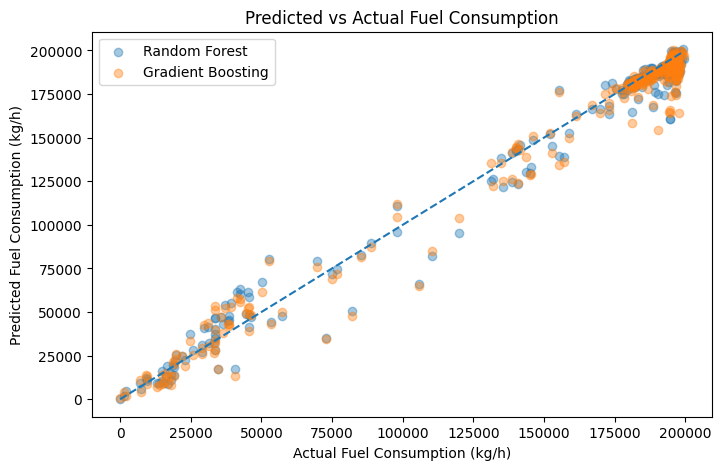

In [66]:
plt.figure()
plt.scatter(y_test, rf_pred, alpha=0.4, label="Random Forest")
plt.scatter(y_test, gbr_pred, alpha=0.4, label="Gradient Boosting")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual Fuel Consumption (kg/h)")
plt.ylabel("Predicted Fuel Consumption (kg/h)")
plt.legend()
plt.title("Predicted vs Actual Fuel Consumption")
plt.show()